In [269]:
import numpy as np 
import nmrfuncs_ibm
import sys, os
from scipy.io import savemat, loadmat
from timeit import default_timer as timer
import importlib
import json
import os
import qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.jobstatus import JobStatus
importlib.reload(nmrfuncs_ibm)

<module 'nmrfuncs_ibm' from '/Users/kis/KIS Dropbox/Kushal Seetharam/NMR Learning/Code/EURIQA/nmrfuncs_ibm.py'>

In [ ]:
IBMQ.enable_account(token='77068d48ad24a6d1622c3fc17c0dd95ad1411195ac03f6b3342b46d63e01262cbb6ddb89893ae704ce8823ce01ec3865e534ce67d4aecf582a8355f5b6bf0321', hub='ibm-q-research-2', group='mit-1', project='main')

In [250]:
provider = qiskit.IBMQ.get_provider(hub='ibm-q-research-2', group='mit-1', project='main')
backend_perth = provider.get_backend("ibm_perth")
backend_jakarta = provider.get_backend("ibmq_jakarta")
backend_lagos = provider.get_backend("ibm_lagos")
backend_bogota = provider.get_backend("ibmq_bogota")
backend_santiago = provider.get_backend("ibmq_santiago")
backend_manila = provider.get_backend("ibmq_manila")

# backend_sim = provider.get_backend("ibmq_qasm_simulator")
backend_sim = Aer.get_backend('qasm_simulator')

In [ ]:
importlib.reload(nmrfuncs_ibm)
spinach_datapath = '/Users/kis/Dropbox/NMR Learning/Code/matlab/spectrumSim/fid_data/'
path = "evolution_circuits/acetonitrile/zf_ibm/"
npoints = 4096
t_ind_List = np.array([i for i in range(npoints)]).astype(float)
gamma_1H = 2.6752 * 1e8; gamma_13C = 0.6728 * 1e8
weights = np.array([gamma_1H, gamma_1H, gamma_1H, gamma_13C]) / gamma_1H
repetitions = 1000; p1q = 0.001; p2q = 0.02

start = timer()

# fid_raw = nmrfuncs_ibm.ZULF_noiselessSim(t_ind_List, path, weights)
# savemat(spinach_datapath + 'fidraw_acetonitrile_zf_qalg_npoints_{:d}_syn_ibm.mat'.format(npoints), {'fid_raw_zf_qalg_ibm': fid_raw}, oned_as='column')

fid_raw = nmrfuncs_ibm.ZULF_snSim(t_ind_List, path, weights, repetitions, backend_sim)
savemat(spinach_datapath + 'fidraw_acetonitrile_zf_qalg_npoints_{:d}_syn_ibm_sn_{:d}.mat'.format(npoints,repetitions), {'fid_raw_zf_qalg_ibm': fid_raw}, oned_as='column')

print(fid_raw)

print(timer()-start)

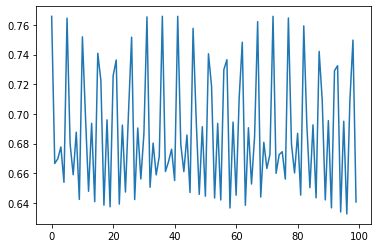

In [90]:
import matplotlib.pyplot as plt
plt.plot(fid_raw)
plt.show()

In [168]:
t_ind_List_exp = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,40,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,63,72,82,90,92,101,103,113,123,134,154,170,195,216,245,247,267,298,329,364,370,411,452,454,504,575,627,699,771,864,977,1090,1192,1295,1429,1593,1768,1953,2117,2313,2518,2755,3001,3259,3526,3793,4050,4091]

In [290]:
fid_raw = nmrfuncs_ibm.ZULF_ibmDataProc(t_ind_List_exp, weights)
savemat(spinach_datapath + 'fidraw_acetonitrile_zf_ibmExp.mat', {'fid_raw_ibm_exp': fid_raw}, oned_as='column')

In [254]:
# rename data files
t = 4
for b in range(8):
    olddata = 'IBM_data/basis_{:d}_U_t_{:d}.txt'.format(int(b),int(t))
    olddict = 'IBM_data/counts/basis_{:d}_U_t_{:d}.json'.format(int(b),int(t))
    if os.path.exists(olddata):
        os.rename(olddata, 'IBM_data/U_t_{:d}_basis_{:d}.txt'.format(int(t),int(b)))
    if os.path.exists(olddict):
        os.rename(olddict, 'IBM_data/counts/U_t_{:d}_basis_{:d}.json'.format(int(t),int(b)))

In [288]:
job_list_large = []
for t_ind in t_ind_List_exp[89::]:
    job_list_indv = nmrfuncs_ibm.ZULF_ibmExp(t_ind, path, weights, repetitions, backend_perth)
    job_list_large += job_list_indv

In [ ]:
for job in job_list_large:
    if job.status() is JobStatus.DONE:
        print(job.name(), job.status())
        avg_pop = nmrfuncs_ibm.counts_to_prob(job.result().get_counts(), repetitions, 4)
        np.savetxt('IBM_data/'+job.name()+'.txt', avg_pop)
        counts = json.dumps(job.result().get_counts())
        f = open('IBM_data/counts/'+job.name()+'.json',"w")
        f.write(counts)
        f.close()